# Ultra-low-latency market data processing: some experiments and thoughts

## INTRODUCTION


This document compares the performances of different Limit Order Book (LOB) implemetations based on ITCH 4.0.1024 market data (See documentation : http://www.borsaistanbul.com/docs/default-source/nasdaq-dokuman/b%C4%B1stech-%C4%B1tch-protocol-specification.pdf?sfvrsn=4). The implementations differ in two main ways :

**1. Data structure to store price-quantity levels ( a simple $\texttt{struct}$ to store prices and  quantities)**

**Vector** →  Price levels are kept in a vector. We iterate the vector from end to beginning to find which price level a new coming order corresponds to. Instruction count depends on the difference between the best price and the order’s price. More sparsity means more instructions.

**Map** →  Price levels are kept in a map. We find the suitable price level with logn instructions every time.



**2. Data structure to store all orders**


**Container 1** → A custom hash table.

**Container 2**  → Improved version of Container 1.

**Sparse** → Google’s sparse hash map implementations

**Boost** → boost::unordered_map

**Std** → std::unordered_map

Different LOB implementations are abbreviated according to these two structures in the figures below. A version consists of two words. Former refers to (1) and latter refers to (2).

### HOW DOES THE VECTOR ALGORITHM WORK



**1. Parsing the ITCH message**
The ITCH message is parsed and add_order(), execute_order() or delete_order() functions are called according to message type.

**2. Order Map**
An order map is crucial since order executed and deleted messages lacks the order book and price level information. Accordingly, we need to store the messages in a container while adding so that we can get relevant order book id and price level while deleting and executing. The add, delete, and execute orders are processed in the following manner:

- Add order function creates a new order and adds it to the order map.

- Execute and delete order functions get the order from the order map.

Order map is simply a hash table. We need a key to insert orders in the hash table. At first glance order ID seems like an appropriate key however order IDs generated by ITCH 4.0.1024 are only unique per order book and side. In that case our first attempt was to create a struct to be used as the key. Our further analysis showed that order IDs are  low endian and only the last 24 bits carry information. Side is a char and either B or S which correspond to 66 and 83 in decimal respectively. Lastly, order book ID doesn't exceed 32 bits. Concatenating these 3 numbers would generate a 64 bit unique number (recall that order IDs are unique per order book and side). So we could use this number as the key.



$$key = (order\_id << 40) \, | \, (order\_book\_id)\, | \, (side)$$
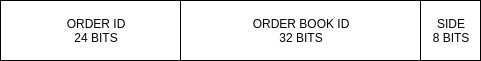


Thus we gain an important amount of speed because every single order undergoes this process.
Keep in mind that using different hash table implementations results in different execution time.(see results)

**3. std::vector<price_level>**

price_level is a struct whose fields are level_id and price. There are two vector<price_level> per order book, one for bids and one for asks. Price levels are sorted and the best offer is placed at the end of the vector. We begin the search for the insertion point from the end and decrement the index for every single time. This is actually an educated guess since orders are expected to be placed near the current best. Though some long term orders may increase the execution time.


**4. s_levels**

When we find the insertion point on the vector<price_level> we get the level id of that price level and update the aggregate quantities on $$s\_levels[order->level\_id].qty$$



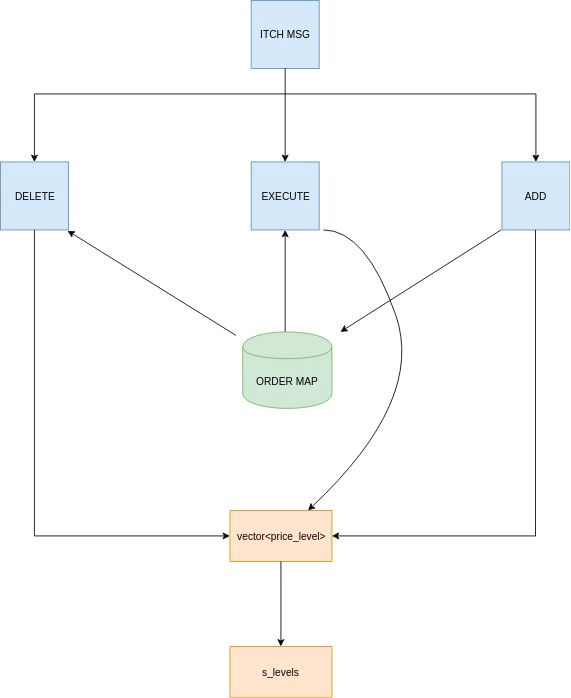

## Input Analysis


Throughput of MOLDUDP 64 Stream in Bytes
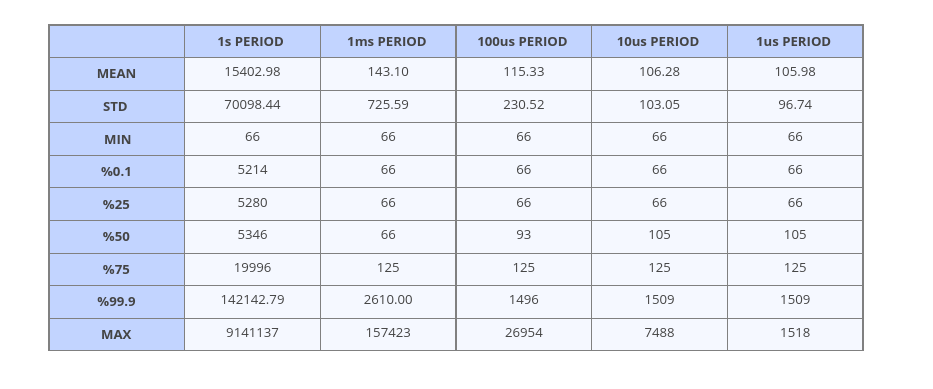


Packet counts per period
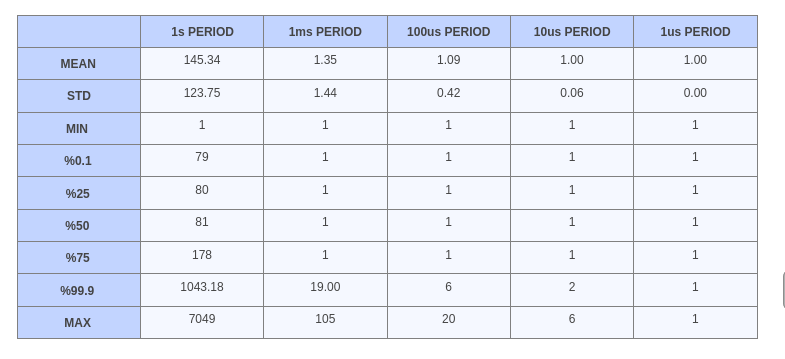


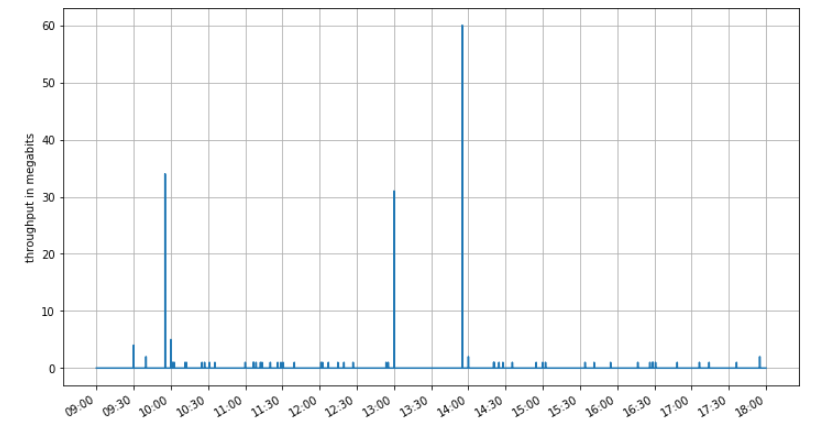

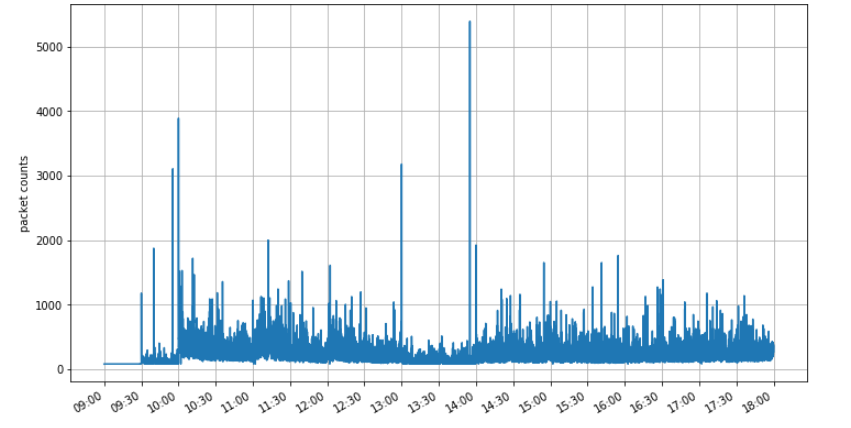

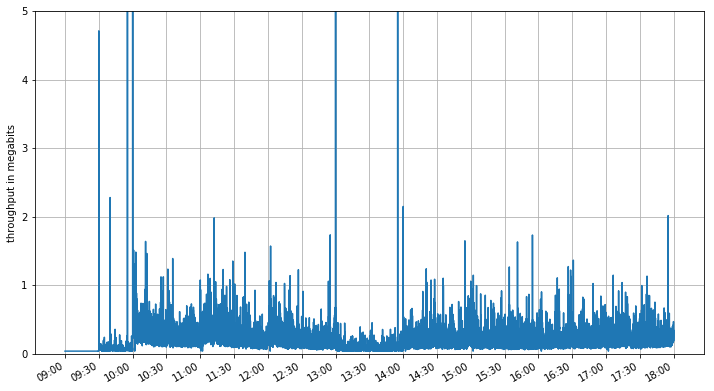

Throughput with zoom.

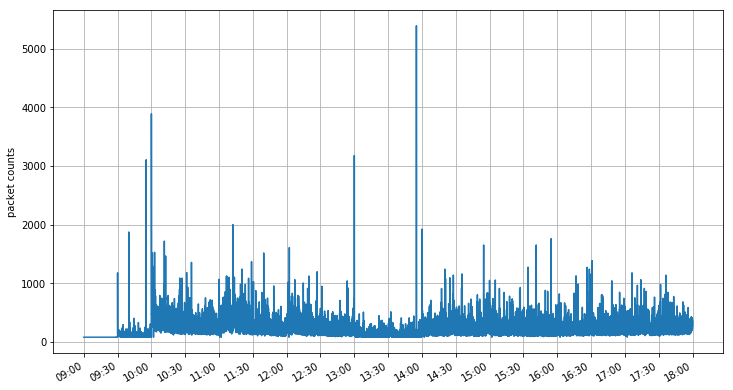

Packets count with zoom.

## Results

These implementations are compatible with  ITCH Version: 4.0.1024. The programs take an ITCH log as input, encode it and build the Limit Order Book. Chronometer starts with the first add message and ends at the very end of the log. We only take add, delete and execute messages into account so the packet counter shows the total amount of add,delete and execute messages. In our case, total packet counter is 2523308.


**Hardware specifications :**

**cpuinfo** : Intel(R) Core(TM) i7-6900K CPU @ 3.20GHz

**meminfo** : 32674540	kB

**compiler** : g++ (GCC) 8.1.0


### ** Effect of Optimization Level **



Since we are in the search of the fastest, we tested our best version of LOB with different optimization levels. O3 gives the best result in our case, thus the rest of the test is conducted with O3 optimization flag. (-march=native flag is also used)

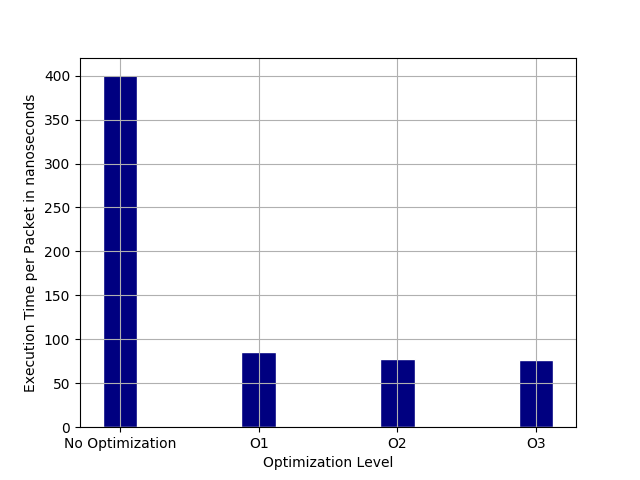

 |  | 
--- | --- | ---
**Optimization Level** | **No Optimization** | **O1** |  **O2**|**O3**
**Execution Time** | 1010509154 ns | 196389061 ns  |  203970628 ns|193840520 ns
**Per Packet** | 400.47 ns  | 85.20 ns  | 77.83 ns |76.87 ns

### **Performance Results of Different Versions**


Flags : -O3 -march=native

 |  | 
--- | --- | ---
**Version** | **Vector Container 1** | **Vector Container 2** | **Vector Sparse** | **Vector Boost** | **Vector Std**
**Execution Time** |193966685 ns | 203933752 ns | 269630889 ns | 334671692 ns | 342085566 ns 
**In Seconds** | 0.19 sec |0.20 sec | 0.27 sec | 0.33 sec | 0.34 sec
**Per Packet** | 76.87 ns |80.82 ns | 106.86 ns | 132.63 ns | 135.57 ns
**Memory Usage** | 1004 MB | 986.4 MB | 943.7 MB | 958.2 MB | 948.4 MB 

 |  | 
--- | --- | ---
**Version** |**Map Container 1** |**Map Container 2** | **Map Sparse** | **Map Boost** | **Map Std**
**Execution Time** |321116176ns | 332395362 ns | 447038170 ns | 482755394 ns | 471415628 ns 
**In Seconds** |0.32 sec | 0.33 sec | 0.45 sec | 0.48 sec | 0.55 sec
**Per Packet** | 127.26 | 131.73 ns | 177.16 ns| 191.32 ns |186.82 ns
**Memory Usage** | 1.7 GB | 1.7 GB | 1.7 GB | 1.7 GB | 1.7 GB

![image.png](graph1.png)

![image.png](graph2.png)

Where reading messages from the file takes 16.4 ns per packet. (Calculated via disabling all LOB functions, only buffer reader functions enabled.)

### Detailed Analysis of Vector Algorithm's Performance

#### All Packages

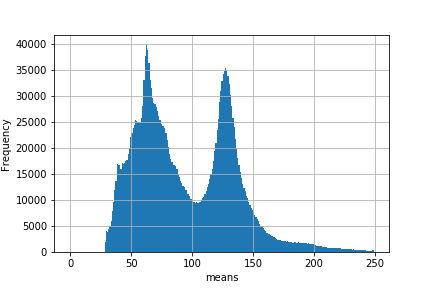
min  :  27<br/>
%1   :  33.0<br/>
%25  :  62.0<br/>
%50  :  88.0<br/>
%75  :  127.0<br/>
%99  :  276.0<br/>
max  :  30781<br/>

#### Add Packages

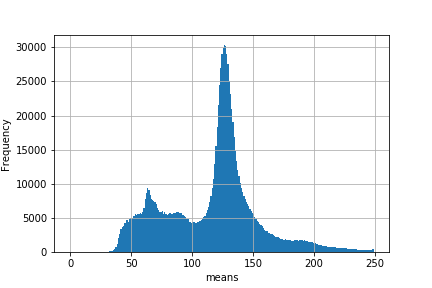
min  :  29<br/>
%1   :  42.0<br/>
%25  :  88.0<br/>
%50  :  124.0<br/>
%75  :  135.0<br/>
%99  :  337.0<br/>
max  :  6874<br/>

#### Delete Packages

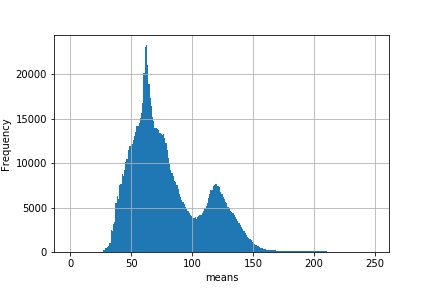
min  :  27<br/>
%1   :  35.0<br/>
%25  :  58.0<br/>
%50  :  72.0<br/>
%75  :  101.0<br/>
%99  :  176.0<br/>
max  :  29160<br/>

#### Execute Packages

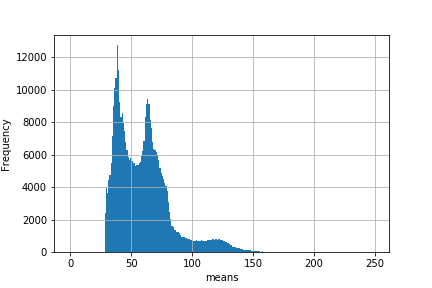
min  :  27<br/>
%1   :  29.0<br/>
%25  :  41.0<br/>
%50  :  57.0<br/>
%75  :  71.0<br/>
%99  :  1162.0<br/>
max  :  1631<br/>

### Detailed Analysis of Map Algorithm's Performance

#### All Packages

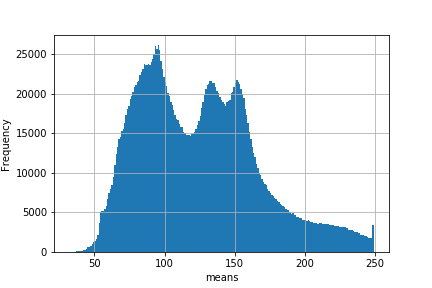
min  :  32<br/>
%1   :  56.0<br/>
%25  :  92.0<br/>
%50  :  125.0<br/>
%75  :  157.0<br/>
%99  :  943.0<br/>
max  :  87936<br/>

#### Add Packages

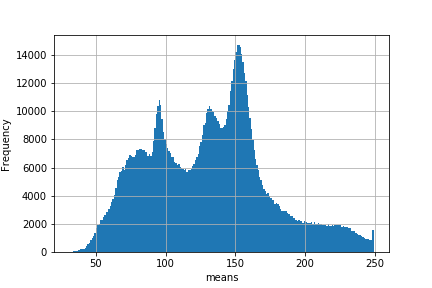
min  :  31<br/>
%1   :  52.0<br/>
%25  :  97.0<br/>
%50  :  136.0<br/>
%75  :  162.0<br/>
%99  :  968.0<br/>
max  :  86611<br/>

#### Delete Packages

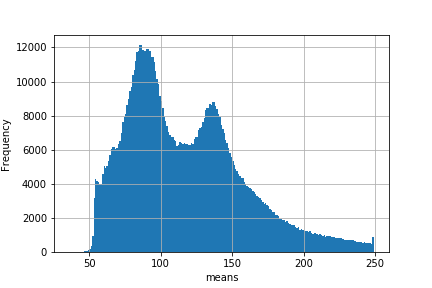
min  :  36<br/>
%1   :  55.0<br/>
%25  :  86.0<br/>
%50  :  112.0<br/>
%75  :  145.0<br/>
%99  :  864.0<br/>
max  :  7415<br/>

#### Execute Packages

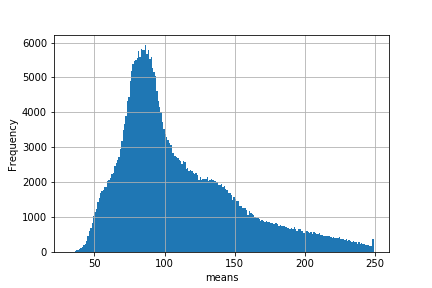
min  :  32<br/>
%1   :  49.0<br/>
%25  :  81.0<br/>
%50  :  101.0<br/>
%75  :  143.0<br/>
%99  :  1008.0<br/>
max  :  87702<br/>

### Why Bytell Performs Better

 
- Open addressing
- Linear probing
- Robin Hood hashing
- Prime number amount of slots
- Upper limit on the probe count
- No (expensive) integer modulus arithmetic



**Open Addressing**

Open addressing means that the underlying storage of the hashtable is a contiguous array. This is not how the $\texttt{std::unordered_map}$ works: it stores every element in a separate heap allocation.

**Linear Probing**

Linear probing means that if you try to insert an element into the array and the current slot is already full, you just try the next slot. If that one is also full, you pick the slot next to that, and so on. There are known problems with this simple approach, but I believe that putting an upper limit on the probe count resolves that.

**Robin Hood Hashing**

Robin Hood hashing means that when you’re doing linear probing, you try to position every element such that it is as close as possible to its ideal position. You do this by moving objects around whenever you insert or erase an element, and the method for doing that is that you take from rich elements and give to poor elements --and that is why it is called Robin Hood. A “rich” element is an element that receives a slot close to its ideal insertion point. A “poor” element is one that’s far away from its ideal insert point.


When you insert a new element using linear probing you count how far you are from your ideal position. If you are further from your ideal position than the current element, you swap the new element with the existing element and try to find a new spot for the existing element.

**Prime number amount of slots**

The prime number amount of slots means that the underlying array has a size of a prime number. Hence, it grows, for example, from 5 slots to 11 slots to 23 slots to 47 slots, so on. Then, to find the insertion point you simply use the modulo operator to assign the hash value of an element to a slot. The other most common choice is to use powers of two to size your array.

**Upper Limit on the Probe Count**

Limiting how many slots the table will look at before it gives up and grows the underlying array. This limit isn't so low that we end up resizing an almost empty array, and also it isn't so high that we end up searching the array all the way up.

### General Comparison of Hftengine's Lob and Orderbook



$\texttt{Orderbook.h}$ is integrated into fully functioning and already existing hftengine project.<br/>

**Important note:** Orderbook is designed in a way such that its static and array indexed fields allow it to be managed without a ``manager". Thus, in the case of a detailed integration into hftengine, we may expect a little bit more performance gain in comparison to the figures plotted below.

Hftengine with Orderbook.

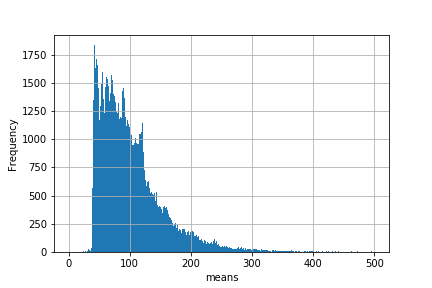
**Descriptive statistics:** <br/>
n: ~130K <br/>
min  :  22.0 ns<br/>
%1   :  40.0 ns<br/>
%25  :  63.0 ns<br/>
%50  :  89.0 ns<br/>
%75  :  123.0 ns<br/>
%99  :  311.0 ns<br/>
max  :  9946121.0 ns<br/>

Hftengine with Lob.

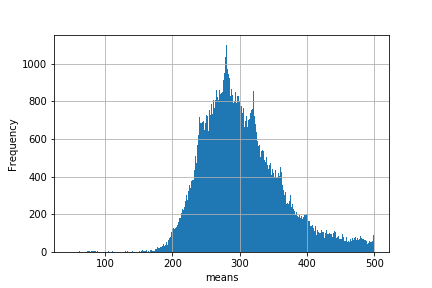
**Descriptive statistics:** <br/>
n: ~130K <br/>
min  :  47.0 ns<br/>
%1   :  199.0 ns<br/>
%25  :  267.0 ns<br/>
%50  :  306.0 ns<br/>
%75  :  368.0 ns<br/>
%99  :  2597.0 ns<br/>
max  :  17002831.0 ns<br/>

## Further Improvement Attempts

In this section you may see our attempts worth mentioning to improve performance.

###  **USING DIFFERENT COMPILERS**




This test is differently conducted on a machine with :

cpuinfo : Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz

meminfo : 16292576 kB



Tested compilers and results are below :

 |  | 
--- | --- | ---
**Compiler** | **clang version 6.0.1** | **gcc 8.1.0** |  **icc 19.0.2.187**
**Per Packet** | 100.14  ns  | 85.20 ns  | 102.06 ns

Since gcc holds the best performance results it is used throughout the project.

### USING FLAT_MAP

Our search for the highest performance data structure to store price levels gave us the opportunity to have a look at boost::container::flat_map. This data structure has the same interface with the std::map and provides with a better latency performance. On average, an implementation with flat_map to store price levels and flat_hash_map to store orders has the execution time 258,692,335 ns in total (102.52 ns on average). This is a significant improvement over std::map however std::vector still performs better.

### USING TWO LEVEL ORDER MAP

Our best version uses a hash table to store all orders. In the search of an even further version, we tried to divide the hash table into 2. First hash table is for the order books and each order book would contain it's own orders. Our goal was to get rid of collision penalty. Here is an illustration of the two level order map :

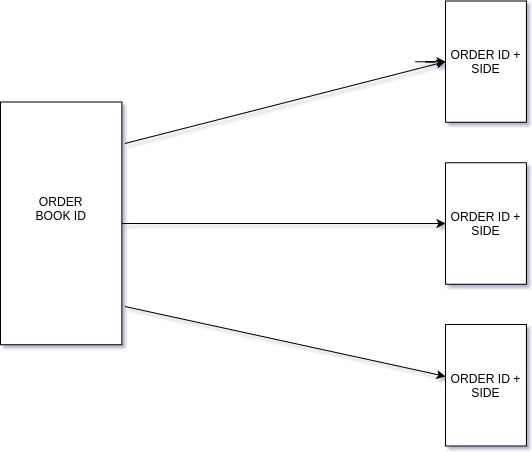

However it turns out cost of hashing once more is more than the gain from collisions.

Average time elapsed per package is increased by 7-8 ns.

### DELETION OF DELETED ORDERS


Our best version still keeps the deleted order in the order map. We tried to delete the delete order messages from the order map too. Our goal was to lower the collision rate. It turns out getting rid of deleted messages in the order map doesn't have a significant contribution on collision rate, or collisions caused by these unneccessary messages are handled in a good way.

### USING COMPUTED GOTO

Since the limit order book consists of different cases depending on the incoming message, we tried to implement a jump table to get rid of branching. Testes are conducted with "-O3 -march=native -fpermissive" flags.

```ruby
static const void* array[] = {&&lab1, &&lab2, &&lab3,&&lab4,&&lab5 };
lab2:
lab3:
for(int i=0;i<orders.sze();i++)
{
    msgtype = orders[i];
    goto *array[msgtype];

    lab1:
    ++adds;
    continue;
    lab4:
    ++deletes;
    continue;
    lab5:
    ++executes;
    continue;

}
    ```
Where lab1,lab2,lab3,lab4,lab5 stand for A,B,C,D,E letters. Iterating this loop 100000000 times takes roughly 420ms.

On the other hand, the loop below takes roughly 340ms.

```ruby
for(int i=0;i<orders.size();i++)
    {
    msgtype = orders[i];
    switch(msgtype)
    {
    case 'A':
    ++adds;
    break;
    case 'D':
    ++deletes;
    break;
    case 'E':
    ++executes;
    break;
    }
}
    ```
It turns out GCC has a better way to generate even faster code. (For further insight check assembly codes generated by the compiler.) So we stick to switch case.

### Using Different Cpu Scheduler

Performance counter stats for 'sudo schedtool -F -p 1 -e taskset -c 8 ./a.out 5':

        284,808861      task-clock (msec)         #    0,995 CPUs utilized          
                 9      context-switches          #    0,032 K/sec                  
                 3      cpu-migrations            #    0,011 K/sec                  
             4.222      page-faults               #    0,015 M/sec                  
     1.053.638.679      cycles                    #    3,699 GHz                    
       687.484.746      instructions              #    0,65  insn per cycle         
       139.408.621      branches                  #  489,481 M/sec                  
         4.403.905      branch-misses             #    3,16% of all branches        
       139.904.208      L1-dcache-loads           #  491,221 M/sec                  
        46.169.217      L1-dcache-load-misses     #   33,00% of all L1-dcache hits  
         3.982.717      LLC-loads                 #   13,984 M/sec                  
         2.414.506      LLC-load-misses           #   60,62% of all LL-cache hits
         
         
         

Performance counter stats for 'sudo schedtool -N -e taskset -c 8 ./a.out 5':

        285,074642      task-clock (msec)         #    0,995 CPUs utilized          
                14      context-switches          #    0,049 K/sec                  
                 6      cpu-migrations            #    0,021 K/sec                  
             4.217      page-faults               #    0,015 M/sec                  
     1.054.559.833      cycles                    #    3,699 GHz                    
       695.670.126      instructions              #    0,66  insn per cycle         
       140.578.037      branches                  #  493,127 M/sec                  
         4.354.196      branch-misses             #    3,10% of all branches        
       141.946.167      L1-dcache-loads           #  497,926 M/sec                  
        46.187.300      L1-dcache-load-misses     #   32,54% of all L1-dcache hits  
         4.010.990      LLC-loads                 #   14,070 M/sec                  
         2.425.685      LLC-load-misses           #   60,48% of all LL-cache hits

Where -N flag indicates normal scheduling, -F flag indicates FIFO scheduling. <br/>
There is no significant improvement however, FIFO scheduling is more favourable in the sense of context-switches. Which may be fatal if it's period covers any order that would trigger the trading strategy.

## Conclusions


Theoretically, using a map for storing price levels seems to be a good idea since the orders can be placed on any price level. However, performance tests show that the worst case (a price level that is far away from the best level) occurs quite rarely. This makes sense because orders are not generated randomly (in that case, it is reasonable to consider that map implementation would have better performance outcomes) but they are placed by traders and traders place their offers mostly around the best level.
Besides, one should keep in mind that the vector implementation has better performance on the average. Execution time of a single packet may fluctuate between 20-3000 ns whereas map implementation has a stable execution time of a single packet (more or less the average execution time itself).